## Table Extraction Demo

This Python notebook demonstrates the extraction of tables from the “Study and Career Choice” books.  
Due to copyright restrictions, scans of all editions cannot be shared. This demo focuses on the 1984 edition.

The tables often span multiple pages and are extracted page by page. Below is an example of the 1984 book scans.

The extraction script is adapted from `table_extraction/84.py` with minor modifications for demonstration purposes.  

### Setting Up the Environment

This Python notebook uses the same Conda environment as the other table extraction scripts.  
To ensure all dependencies are available, please set up the environment as follows:

First, create the environment from the provided `.yml` file by running:

```bash
conda env create -f table_extraction/environment.yml
```

Then, activate the environment using:

```bash
conda activate rwi_uni_subjects_env
```

### Example Table Page

In the following code block, we present an example page from one of the tables in the 1984 edition of the “Study and Career Choice” book.

In these tables, the columns represent different universities, while the rows correspond to study programs.  
Each cell in the table may contain one or more icons that convey specific information, such as:

- **Full Study** / **Partial Study** / ...
- **Special Conditions** (e.g., restricted access or requirements)

The extraction process focuses on correctly identifying and interpreting these structures across pages.

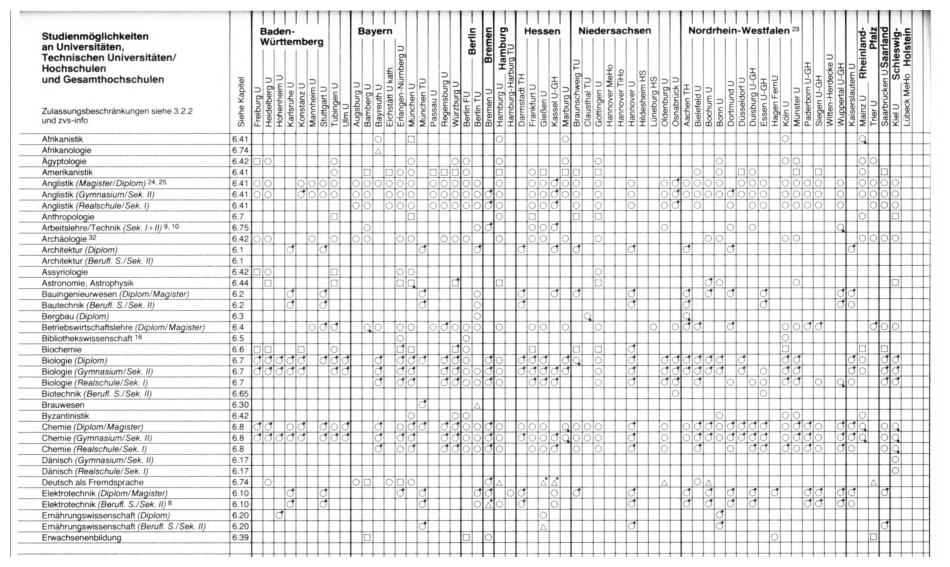

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

img_path = "./table_extraction/tables/Uni/84/screenshots/38_1.png"
img = Image.open(img_path)
img = img.resize((int(img.width * 1.2), int(img.height * 1.2))) 
plt.figure(figsize=(12, 8))  
plt.imshow(img)
plt.axis('off')
plt.show()

### Image Preprocessing

For the extraction algorithm, we manually preprocess the table images to ensure optimal performance during line detection and template matching.

Specifically, we cut out only the inner grid of the table, omitting the axis labels (university names and study programs).  
This is necessary because the algorithm focuses solely on detecting and matching the icons within the table cells, without interpreting the textual information.

Additionally, if necessary, the images are rotated to achieve a straight alignment, as the algorithm assumes properly oriented input images.

After preprocessing, the resulting images look as follows:


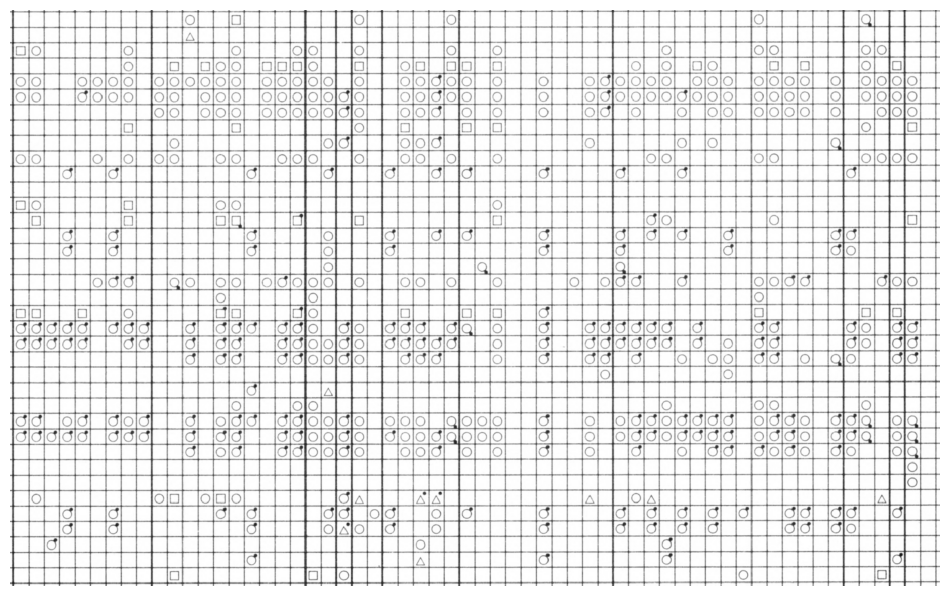

In [ ]:
img_path = "./table_extraction/tables/Uni/84/screenshots_cutout/38_1.png"
img = Image.open(img_path)
img = img.resize((int(img.width * 1.2), int(img.height * 1.2)))  
plt.figure(figsize=(12, 8))  
plt.imshow(img)
plt.axis('off')
plt.show()

### Axis Labels

The axis labels have been manually extracted and are stored at: ```table_extraction/tables/Uni/84/axis_labels```

After the table extraction process, the axis labels are combined with the extracted table data to recover the information about university names and study programs in the final dataset.

Each line in the corresponding text files represents a single column or row of the original tables.

The following code block shows the first ten lines of the manually extracted column labels, which correspond to the university names:


In [ ]:
axis_labels = "./table_extraction/tables/Uni/84/axis_labels/Name_Unis_S.38.txt"

# Open and read the first 10 lines
with open(axis_labels, 'r') as file:
    lines = [file.readline().strip() for _ in range(10)]

for line in lines:
    print(line)
print("...") 

Freiburg U
Heidelberg U
Hohenheim U
Karlsruhe U
Konstanz U
Mannheim U
Stuttgart U
Tübingen U
Ulm U
Augsburg U
...


### Template Matching (Mappings)

To extract the positions of the symbols within the tables, several templates, serving as example images, are used.

The following code block defines the mappings for these icons. Each mapping includes:
- A **name**, which corresponds to the filename of the template stored in the subfolder ```table_extraction/tables/Uni/84/icons```
- A **keyword**, a numerical code that the algorithm assigns to a recognized icon. This code will be stored in the resulting dataframe.
- An optional **threshold** parameter, specifying the minimum similarity score required for an icon to be considered a match.

The algorithm uses these templates during the matching process to identify and categorize the icons in the extracted tables.

Below, the code block lists the mappings and displays example images of the templates.


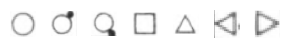

In [ ]:
from table_extraction.table_extractor import *

mappings = {
    "Full_Study": {"keyword": "1", "threshold": 0.67},
    "Full_Study_WS_Required": {"keyword": "11", "threshold": 0.79},
    "Full_Study_WS_Recommended": {"keyword": "12", "threshold": 0.8},
    "Specialization": {"keyword": "3", "threshold": 0.75},
    "Postgraduate_Study": {"keyword": "5", "threshold": 0.72},
    "Partial_Study_Until": {"keyword": "7b", "threshold": 0.72},
    "Partial_Study_From": {"keyword": "7a", "threshold": 0.72},
}

template_image_folder = "./table_extraction/tables/Uni/84/icons"
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, len(mappings), figsize=(3, 3))  # 1 row, as many columns as mappings

if len(mappings) == 1:
    axes = [axes]

# Loop through the mappings and display each image in the corresponding subplot
for ax, (key, value) in zip(axes, mappings.items()):
    image_path = os.path.join(template_image_folder, f"{key}.png") 
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()

### Setting Up the Table_Extractor

The `Table_Extractor` class is implemented in: ```table_extraction/table_extractor.py```

It can be customized by passing different arguments to adapt to the specific characteristics of the input data.  
This high degree of configurability is necessary due to the varying quality of the book scans and the different table layouts across the years.

The following code block shows how the parameters are set for extracting tables from the 1984 edition and demonstrates how the first page is processed.

To define the table structure, each column and row is determined by identifying the two nearest detected lines that form a cell boundary.  
Afterwards, the number of extracted columns and rows is compared with the manually extracted number of axis labels.  
This validation step ensures that the table structure has been correctly detected and aligns with the expected layout.

In [6]:
type="Uni"
year="84"

table_extractor = Table_Extractor(
        year, # defines the year; used to find the correct subfolder
        type, # defines the type (university/university of applies sciences); used to find the correct subfolder
        mappings, # defines the mappings; also used to find the template in the template folder
        show_lines=False, # can be used to display detected lines
        min_dist=25, # minimal distance between two lines
        line_detection_threshold=28, # sets minimal line width
        confidence_based=False, # if set to True, the icon with the highest confidence (similarity value) wins and gets written into a cell. alternatively, manually inserted threshold can be inserted via mappings
    )


page_1 = 38
# extracts of page 38 and compares number of detected axis labels with manually extracted axis labels:
page1 = table_extractor.extract_semi_page(
    f"./table_extraction/tables/{type}/{year}/axis_labels", f"Name_{type}s_S.{page_1}", f"Studiengänge_{type}s_S.{page_1}", f"{page_1}_1"
)



File 38_1
Detected columns:  60/60
Detected rows:  37/37



### Validation of Detected Lines

To verify the correctness of the extraction, the detected lines are drawn onto the table images after each extraction step.

In the following block, we visualize these results to illustrate how the validation process works:
- **Blue lines** represent the detected horizontal grid lines.
- **Purple lines** represent the detected vertical grid lines.

If the overlaid grid closely matches the original table structure, the line detection is considered successful.


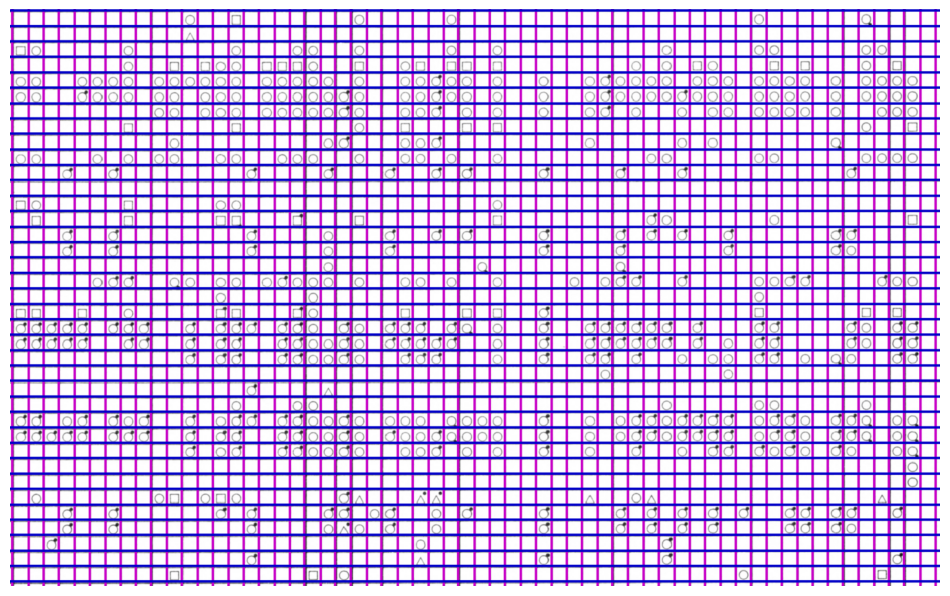

In [ ]:
img_path = "./table_extraction/tables/Uni/84/demo/detected_lines.png"
img = Image.open(img_path)
img = img.resize((int(img.width * 1.2), int(img.height * 1.2)))  
plt.figure(figsize=(12, 8))  
plt.imshow(img)
plt.axis('off')
plt.show()

### Combining the Results

In the final step, the extracted tables from all subsequent pages are combined into a single dataframe, `final_df`, which contains the complete results for the corresponding year.

In [8]:
page_2 = 39
page2 = table_extractor.extract_page(
    f"./table_extraction/tables/{type}/{year}/axis_labels",
    f"Name_{type}s_S.{page_2}",
    f"Studiengänge_{type}s_S.{page_2}_1",
    f"Studiengänge_{type}s_S.{page_2}_2",
    f"{page_2}_1",
    f"{page_2}_2",
)

page_3 = 40
page3 = table_extractor.extract_page(
    f"./table_extraction/tables/{type}/{year}/axis_labels",
    f"Name_{type}s_S.{page_3}",
    f"Studiengänge_{type}s_S.{page_3}_1",
    f"Studiengänge_{type}s_S.{page_3}_2",
    f"{page_3}_1",
    f"{page_3}_2",
)

final_df = pd.concat([page1, page2, page3], axis=0)
table_extractor.df_to_excel_formatting(final_df)
print(
    f"Extraction results have been written to ./table_extraction/tables/Uni/84/results"
)


File 39_1
Detected columns:  60/60
Detected rows:  35/35


File 39_2
Detected columns:  60/60
Detected rows:  35/35


File 40_1
Detected columns:  60/60
Detected rows:  35/35


File 40_2
Detected columns:  60/60
Detected rows:  34/34

Extraction results have been written to ./table_extraction/tables/Uni/84/results


### Results

An excerpt of the results for this demo are shown in the code block below.  
All interim and final results for the 1984 edition are stored in:

`./table_extraction/tables/Uni/84/results`  🔗[View the folder on GitHub](https://github.com/Boshl/RWI-UNI-SUBJECTS/tree/main/table_extraction/tables/Uni/84/results)

- The file `Uni_84.xlsx` contains the combined final results.  
- The other files in the folder contain intermediate results generated during processing.


In [ ]:
from IPython.display import display

display(final_df.fillna('').head())

,Freiburg U,Heidelberg U,Hohenheim U,Karlsruhe U,Konstanz U,Mannheim U,Stuttgart U,Tübingen U,Ulm U,Augsburg U,...,Siegen U-GH,Witten-Herdecke U,Wuppertal U-GH,Kaiserslautern U,Mainz U,Trier U,Saarbrücken U,Kiel U,Lübeck MeHo,Kassel GH
Afrikanistik,,,,,,,,,,,...,,,,,12,,,,,
Afrikanologie,,,,,,,,,,,...,,,,,,,,,,
Ägyptologie,3,1,,,,,,1,,,...,,,,,1,1,,,,
Amerikanistik,,,,,,,,1,,,...,3,,,,1,,3,,,
Anglistik (Magister),1,1,,,1,1,1,1,,1,...,1,,1,,1,1,1,1,,
